In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import math
import collections
import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# !! tar -xvjf data.tar.bz2

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
print(all_codones[:10])

[['MAF', 'SAE', 'DVL', 'KEY', 'DRR', 'RRM', 'EAL', 'LLS', 'LYY', 'PND', 'RKL', 'LDY', 'KEW', 'SPP', 'RVQ', 'VEC', 'PKA', 'PVE', 'WNN', 'PPS', 'EKG', 'LIV', 'GHF', 'SGI', 'KYK', 'GEK', 'AQA', 'SEV', 'DVN', 'KMC', 'CWV', 'SKF', 'KDA', 'MRR', 'YQG', 'IQT', 'CKI', 'PGK', 'VLS', 'DLD', 'AKI', 'KAY', 'NLT', 'VEG', 'VEG', 'FVR', 'YSR', 'VTK', 'QHV', 'AAF', 'LKE', 'LRH', 'SKQ', 'YEN', 'VNL', 'IHY', 'ILT', 'DKR', 'VDI', 'QHL', 'EKD', 'LVK', 'DFK', 'ALV', 'ESA', 'HRM', 'RQG', 'HMI', 'NVK', 'YIL', 'YQL', 'LKK', 'HGH', 'GPD', 'GPD', 'ILT', 'VKT', 'GSK', 'GVL', 'YDD', 'SFR', 'KIY', 'TDL', 'GWK', 'FTP'], ['AFS', 'AED', 'VLK', 'EYD', 'RRR', 'RME', 'ALL', 'LSL', 'YYP', 'NDR', 'KLL', 'DYK', 'EWS', 'PPR', 'VQV', 'ECP', 'KAP', 'VEW', 'NNP', 'PSE', 'KGL', 'IVG', 'HFS', 'GIK', 'YKG', 'EKA', 'QAS', 'EVD', 'VNK', 'MCC', 'WVS', 'KFK', 'DAM', 'RRY', 'QGI', 'QTC', 'KIP', 'GKV', 'LSD', 'LDA', 'KIK', 'AYN', 'LTV', 'EGV', 'EGF', 'VRY', 'SRV', 'TKQ', 'HVA', 'AFL', 'KEL', 'RHS', 'KQY', 'ENV', 'NLI', 'HYI', 'LTD', 'K

In [8]:
######################

In [9]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


glob_prob = None
def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod if random.random() >= glob_prob[key]]

def make_dictionary(all_codones):
    global glob_prob
    
    flat_codones = flatten(all_codones)
    counter = collections.Counter(flat_codones)
    print(counter.most_common(5))
    unique_codones = set(flat_codones)
    
    # Subsampling
    glob_prob = dict()
    sample_rate = 1e-5
    num_total_codones = len(flat_codones)
    for codone in unique_codones:
        # https://github.com/chrisjmccormick/word2vec_commented/blob/07e9576bbf05c9cefaf8aa590555ce9bc04b041b/word2vec.c#L740
        freq = float(counter[codone]) / num_total_codones
        ran = 1 - math.sqrt(sample_rate / freq)
        glob_prob[codone] = ran
    
    lst_sorted = sorted(unique_codones, key=counter.get, reverse=True)
    for i in range(5):
        print(lst_sorted[i], glob_prob[lst_sorted[i]])
    for i in range(-5, -1):
        print(lst_sorted[i], glob_prob[lst_sorted[i]])
    print(lst_sorted[:5])
    dictionary = {cod: i for i, cod in enumerate(lst_sorted)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [10]:
dictionary = make_dictionary(all_codones)

[('AAA', 152576), ('LLL', 131965), ('ALA', 127540), ('LAA', 126274), ('AAL', 124613)]
AAA 0.905112767968274
LLL 0.8979714982063004
ALA 0.896216650220804
LAA 0.8956976912938254
AAL 0.8950048557166559
IBY -36.06388080058536
XRT -36.06388080058536
FVX -36.06388080058536
EXG -36.06388080058536
['AAA', 'LLL', 'ALA', 'LAA', 'AAL']


In [11]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [12]:
######################

In [13]:
class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver()  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_embedding(self):
        with tf.name_scope("embed"):
            self.embed_matrix = tf.Variable(tf.random_uniform([self.vocab_size,
                                                               self.embed_size], -1.0, 1.0),
                                            name='embed_matrix')

    def _create_loss(self):
        with tf.name_scope("loss"):
            embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name='nce_weight')
            nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                      biases=nce_bias,
                                                      labels=self.target_words,
                                                      inputs=embed,
                                                      num_sampled=self.num_sampled,
                                                      num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(self.loss,
                                                                                 global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [14]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 25  # Number of negative examples to sample.
LEARNING_RATE = .01
NUM_TRAIN_STEPS = 1000000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

In [15]:
######################

In [16]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [ ]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

    config = tf.ConfigProto(
        #device_count = {'GPU': 0},
        gpu_options=gpu_options
    )
    with tf.Session(graph=g, config=config) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state('checkpoints')
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path + '.meta'):
            print('restored checkpoint')
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

In [ ]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

restored checkpoint
INFO:tensorflow:Restoring parameters from checkpoints/skip-gram-377999
Average loss at step 379999:  55.2
Average loss at step 381999:  19.8
Average loss at step 383999:  15.2
Average loss at step 385999:  12.2
Average loss at step 387999:  11.4
Average loss at step 389999:  11.5
Average loss at step 391999:  10.2
Average loss at step 393999:   9.4
Average loss at step 395999:  12.1
Average loss at step 397999:  12.4
Average loss at step 399999:  12.7
Average loss at step 401999:  11.7
Average loss at step 403999:  12.0
Average loss at step 405999:  12.1
Average loss at step 407999:  10.0
Average loss at step 409999:  10.4
Average loss at step 411999:  10.1
Average loss at step 413999:  11.7
Average loss at step 415999:  11.1
Average loss at step 417999:  11.3
Average loss at step 419999:  12.3
Average loss at step 421999:  10.8
Average loss at step 423999:  12.5
Average loss at step 425999:  12.2
Average loss at step 427999:  11.4
Average loss at step 429999:   9.8

Average loss at step 843999:  11.2
Average loss at step 845999:  11.1
Average loss at step 847999:  11.6
Average loss at step 849999:  11.9
Average loss at step 851999:  12.3
Average loss at step 853999:   9.9
Average loss at step 855999:  11.5
Average loss at step 857999:  10.7
Average loss at step 859999:  10.4
Average loss at step 861999:   9.6
Average loss at step 863999:   8.9
Average loss at step 865999:  11.4
Average loss at step 867999:  11.2
Average loss at step 869999:  11.7
Average loss at step 871999:  11.1
Average loss at step 873999:   9.1
Average loss at step 875999:  10.2
Average loss at step 877999:   9.6
Average loss at step 879999:   8.5
Average loss at step 881999:  11.9
Average loss at step 883999:  11.2
Average loss at step 885999:  10.8
Average loss at step 887999:  12.2
Average loss at step 889999:  12.0
Average loss at step 891999:  11.1
Average loss at step 893999:  12.0
Average loss at step 895999:  11.2
Average loss at step 897999:  11.8
Average loss at step

Average loss at step 1303999:  10.2
Average loss at step 1305999:   8.9
Average loss at step 1307999:  12.0
Average loss at step 1309999:  11.6
Average loss at step 1311999:  10.6
Average loss at step 1313999:   9.4
Average loss at step 1315999:   8.4
Average loss at step 1317999:   9.3
Average loss at step 1319999:   9.1
Average loss at step 1321999:  11.8
Average loss at step 1323999:  11.8
Average loss at step 1325999:  11.2
Average loss at step 1327999:  11.6
Average loss at step 1329999:  10.2
Average loss at step 1331999:   9.8
Average loss at step 1333999:   9.3
Average loss at step 1335999:   8.6
Average loss at step 1337999:   8.2
Average loss at step 1339999:   9.2
Average loss at step 1341999:  10.4
Average loss at step 1343999:   9.0
Average loss at step 1345999:   9.7
Average loss at step 1347999:  11.2
Average loss at step 1349999:  11.2
Average loss at step 1351999:  10.4
Average loss at step 1353999:  11.3
Average loss at step 1355999:  10.4
Average loss at step 1357999

In [ ]:
######################

In [ ]:
tsne = TSNE(n_components=2, random_state=42, n_iter=5000, learning_rate=400.0, perplexity=40)
XX = tsne.fit_transform(final_embed_matrix)

In [ ]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,2.227936,0.670386,AAA
1,2.086371,0.717923,LLL
2,2.237468,0.564410,ALA
3,2.513015,0.805398,LAA
4,2.732311,0.920428,AAL


In [ ]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

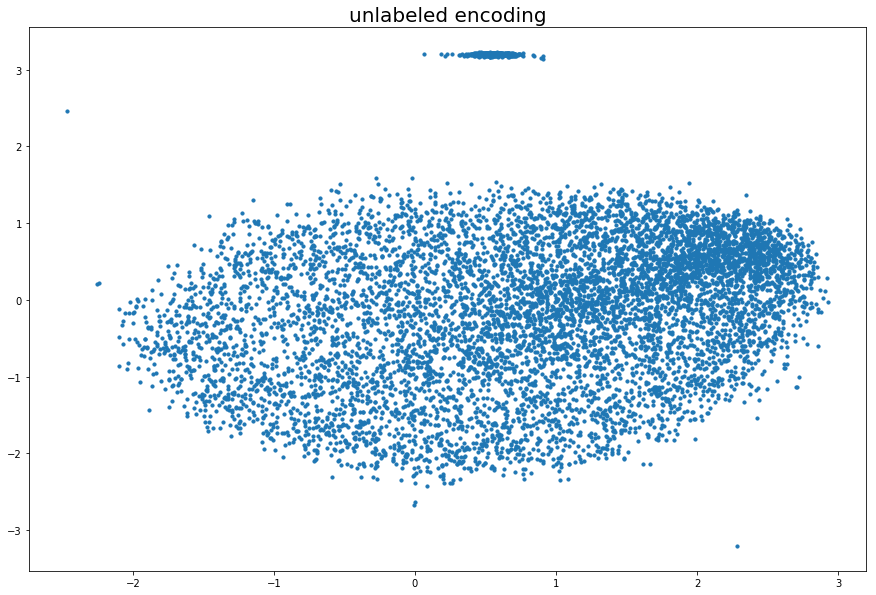

In [ ]:
plot_tsne_df(tsne_df)

In [ ]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [ ]:
######################

In [ ]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [ ]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [ ]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,PST,-1.033333,95.098800,16.000000,105.933333
1,CNQ,-1.500000,115.124900,17.000000,122.133333
2,CAH,0.366667,103.786700,15.666667,116.766667
3,LPI,2.233333,107.810133,20.333333,148.700000
4,XQP,-2.550000,112.622200,18.500000,128.250000


In [ ]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,PST,-1.033333,95.098800,16.000000,105.933333,2.038746,0.546431
1,CNQ,-1.500000,115.124900,17.000000,122.133333,-1.143040,1.024501
2,CAH,0.366667,103.786700,15.666667,116.766667,0.481751,-1.872856
3,LPI,2.233333,107.810133,20.333333,148.700000,1.972386,0.366923
4,XQP,-2.550000,112.622200,18.500000,128.250000,0.597380,3.209378


In [ ]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

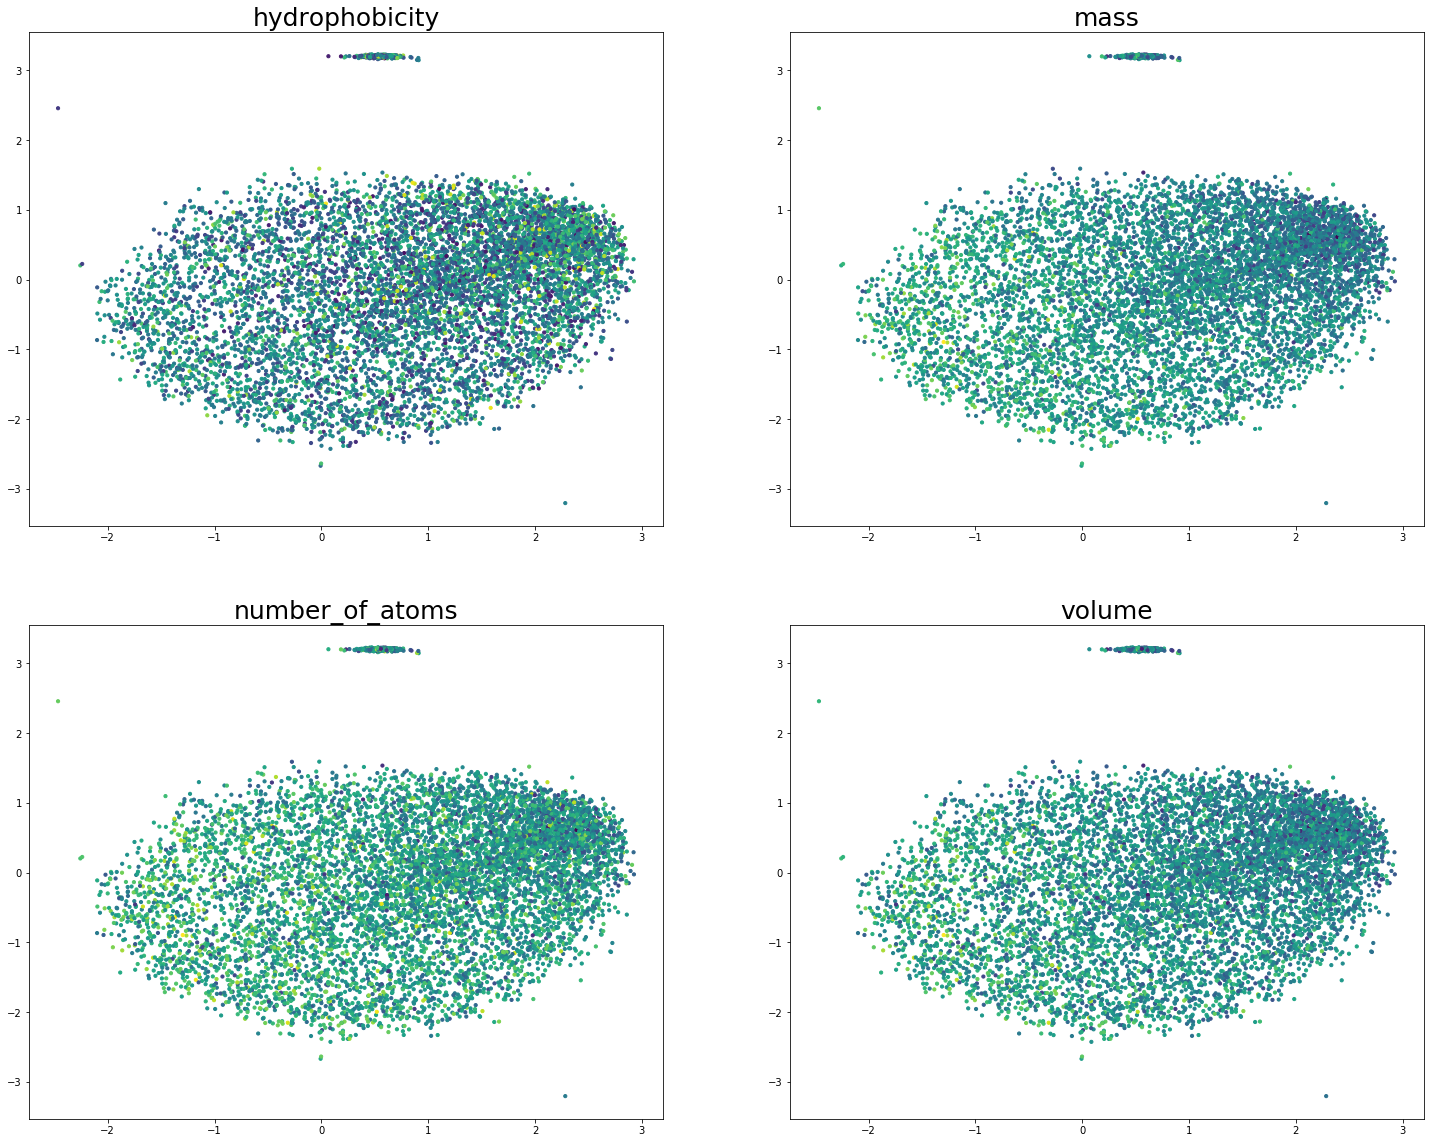

In [ ]:
plot_embedding_properties(final_df)

In [ ]:
######################

In [ ]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

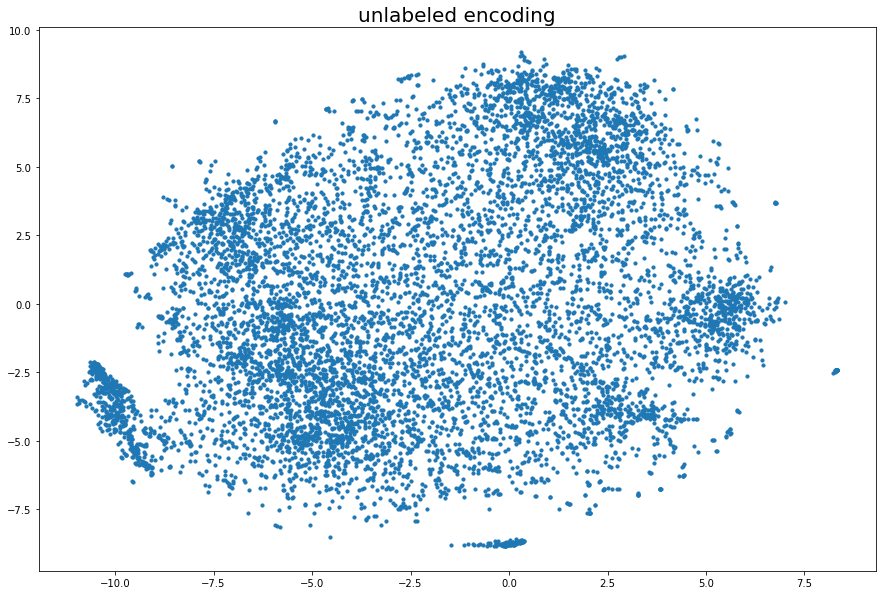

In [ ]:
plot_tsne_df(gensim_tsne_df)

In [ ]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

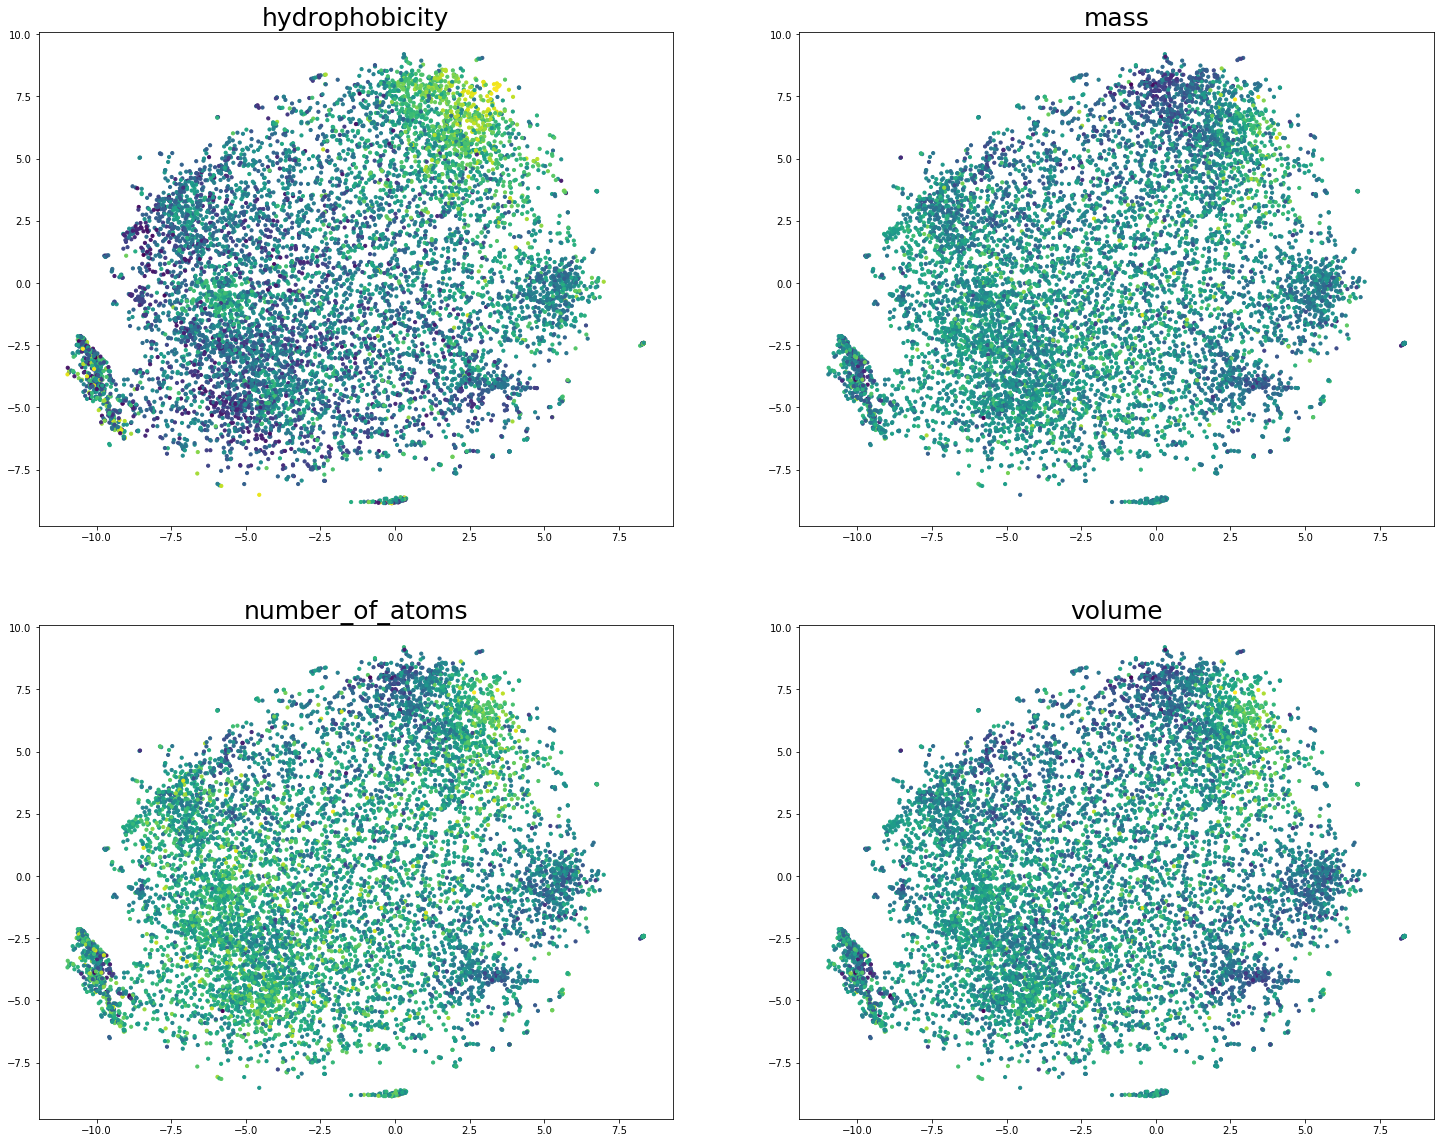

In [ ]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/